# Hard contraints

This notebook presents an initial experiment that evaluates the coverage of PostNL pickup points under a strict no-fly policy. In this scenario, UAVs are not allowed to fly in areas where it is not possible to maintain a minimum 20-meter distance from people. This includes:
- Residential areas
- Retail zones
- Religious sites
- Cultural sites
- Recreational zones

In [ ]:
# import necessary libraries
import pandas as pd
import geopandas as gpd

In [ ]:
# read the GeoJSON files
data_breda = gpd.read_file(f"../3.no_fly_zones/output/data_for_graph_breda.geojson")
data_borsele = gpd.read_file(f"../3.no_fly_zones/output/data_for_graph_borsele.geojson")
data_aw = gpd.read_file(f"../3.no_fly_zones/output/data_for_graph_alphen-waddinxveen.geojson")

In [ ]:
# set no-fly zones based on area type
# If the area type is one of the specified categories, set risk to 'no_fly_zone'
# Otherwise, keep the existing risk value
def set_no_fly_zone(row):
    if row['area_type'] in ['Residential areas', 'Retail zones', 'Religious sites', 'Cultural sites', 'Recreational zones']:
        return 'no_fly_zone'
    return row['risk']

data_breda['risk'] = data_breda.apply(set_no_fly_zone, axis=1)
data_borsele['risk'] = data_borsele.apply(set_no_fly_zone, axis=1)
data_aw['risk'] = data_aw.apply(set_no_fly_zone, axis=1)

In [4]:
# find percentage of postnl points that are within the no-fly zones
def calculate_percentage_within_no_fly_zones(postnl_points, no_fly_zones):
    """
    Calculate the percentage of PostNL points that are within no-fly zones.

    Args:
        postnl_points (GeoDataFrame): PostNL points with geometry.
        no_fly_zones (GeoDataFrame): No-fly zones with geometry.

    Returns:
        float: Percentage of PostNL points within no-fly zones.
    """
    if postnl_points.empty or no_fly_zones.empty:
        return 0.0

    # Check if each PostNL point is within any no-fly zone
    within_no_fly_zone = postnl_points.geometry.apply(
        lambda point: any(no_fly_zones.geometry.contains(point))
    )

    # Calculate the percentage
    percentage = (within_no_fly_zone.sum() / len(postnl_points)) * 100
    return percentage

In [5]:
def get_gdfs(gdf, depot, all=True):
    """
    Reads a GeoJSON file

    Args:
        file_path (str): Path to the GeoJSON file.
        depot (str): The depot city to filter distribution points.
        all (bool): If True, return separate dataframes for lines, polygons, postnl points, distribution points and no fly zones.
    """
    gdf = gdf.to_crs(epsg=28992)

    if all: # Get separate dataframes for lines, polygons, postnl points, distribution points and no fly zones
        print("Getting separate dataframes for lines, polygons, postnl points, distribution points and no fly zones")

        lines_gdf = gdf[(gdf.geometry.type == 'LineString') & (gdf['risk'] != 'no_fly_zone')].copy()
        lines_gdf['risk'] = lines_gdf['risk'].astype(float).round(3).fillna(0) # Ensure 'risk' is float and fill NaNs with 0
        if lines_gdf.empty:
            print("No lines found in the GeoJSON file.")

        polygons_gdf = gdf[(gdf.geometry.type == 'Polygon') & (gdf['risk'] != 'no_fly_zone')].copy()
        polygons_gdf['risk'] = polygons_gdf['risk'].astype(float).round(3).fillna(0)  # Ensure 'risk' is float and fill NaNs with 0
        if polygons_gdf.empty:
            print("No polygons found in the GeoJSON file.")

        post_nl_gdf = gdf[gdf['area_type'] == 'postnl point'].copy()
        post_nl_gdf['risk'] = post_nl_gdf['risk'].astype(float).round(3).fillna(0)  # Ensure 'risk' is float and fill NaNs with 0
        if post_nl_gdf.empty:
            print("No PostNL points found in the GeoJSON file.")

        no_fly_zones_gdf = gdf[gdf['risk'] == 'no_fly_zone'].copy()
        no_fly_zones_gdf['area_type'] = 'No-fly zone'  # Ensure area_type is set correctly
        if no_fly_zones_gdf.empty:
            print("No no-fly zones found in the GeoJSON file.")

        print(f"Looking for distribution points in {depot}")
        distribution = get_distribution_points('/Users/cmartens/Documents/thesis_cf_martens/distribution_centers/output/postnl_distribution_cleaned.json', depot)
        print(f"Found {len(distribution)} distribution points in {depot}")
        if distribution.empty:
            print("No distribution points found for the depot.")

        # Set height and risk to 0 for postnl points
        post_nl_gdf['Height'] = 0
        post_nl_gdf['risk'] = 0

        # Add distribution point to the postnl points dataframe
        post_nl_gdf = pd.concat([post_nl_gdf, distribution], ignore_index=True)

        print(f"Found {len(lines_gdf)} lines, {len(polygons_gdf)} polygons, {len(post_nl_gdf)} postnl points, {len(distribution)} distribution point and {len(no_fly_zones_gdf)} no-fly zones")

        return gdf, lines_gdf, polygons_gdf, post_nl_gdf, no_fly_zones_gdf

    # Get only the main dataframe
    print(f"Getting only the main dataframe")

    if gdf.empty:
        print("No data found in the GeoJSON file.")
        return None

    print(f"Found {len(gdf)} geometries in the GeoJSON file.")

    return gdf

def get_distribution_points(file_path, depot):
    """
    Reads a GeoJSON file and returns the distribution points
    for all depot cities in the provided list.

    Args:
        file_path (str): Path to the GeoJSON file.
        depot (list[str]): List of depot cities to filter distribution points.

    Returns:
        GeoDataFrame or None: Filtered distribution points or None if empty.
    """
    gdf = gpd.read_file(file_path)
    gdf = gdf.to_crs(epsg=28992)

    # Filter for multiple depots and combine
    distribution = gdf[gdf['depotCity'].isin(depot)].copy()
    distribution.rename(columns={'type': 'area_type'}, inplace=True)

    if distribution.empty:
        print("No distribution points found in the GeoJSON file.")
        return None

    return distribution

In [6]:
def plot_polygons_static(gdf_polygons, city_name="Unknown",
                         no_fly_zones_gdf=None, postnl_points=None, title=None, focus_radius_km=17):
    """
    Plot area-type polygons with consistent color coding on a static background map,
    including optional overlays for no-fly zones and PostNL/distribution points.

    Args:
        gdf_polygons (GeoDataFrame): Polygons with an 'area_type' column and EPSG:28992 CRS.
        city_name (str): Name of the city to use in the plot title.
        no_fly_zones_gdf (GeoDataFrame): Optional. Polygons representing no-fly zones.
        postnl_points (GeoDataFrame): Optional. Points with 'ntype' column: 'postnl' or 'distribution'.

    Returns:
        matplotlib.figure.Figure: The generated matplotlib figure.
    """

    import matplotlib.pyplot as plt
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    import contextily as ctx

    area_color_map = {
        # Infrastructuur
        'Motorways and major roads': '#E31A1C',       # felrood
        'Regional roads': '#F46D43',                  # vurig oranje
        'Tracks and rural access roads': '#D95F02',   # donkeroranje
        'Living and residential streets': '#FFCB05',  # felgeel
        'Pedestrian and cycling paths': '#66C2A5',    # turquoisegroen
        'Railways': '#4B4B4B',                        # donkergrijs
        'Helipads': '#F0027F',
        'Airports and airfields': '#A6CEE3',

        # Energie & communicatie
        'Power lines': '#999999',
        'Power plants': '#FF8C00',
        'Communication towers': '#FB9A99',
        'High infrastructures': '#888888',

        # Gebouwd gebied
        'Industrial zones': '#377EB8',               # helderblauw
        'Commercial zones': '#FFC300',               # goudgeel
        'Retail zones': '#FF8C00',                   # warm oranje
        'Residential areas': '#FFA07A',              # warm zalm/oranjerood – beter onderscheid met 'Retail zones'
        'Schools and universities': '#DAA520',
        'Hospitals': '#DC143C',
        'Care homes': '#FF9999',
        'Prisons': '#696969',
        'Religious sites': '#C71585',
        'Cemeteries': '#556B2F',
        'Cultural sites': '#8A2BE2',

        # Natuur
        'Parks': '#7CFC00',                          # limegroen
        'Recreational zones': '#20B2AA',
        'Meadows and open grass': '#9ACD32',         # geelgroen
        'Forests and woodlands': '#228B22',          # bosgroen
        'Agricultural lands': '#BFD92E',             # helderder dan '#ADDE87'
        'Wetlands': '#66B2FF',                       # licht, helder blauw
        'Lakes and ponds': '#1E90FF',                # diepblauw (meer contrast met 'Wetlands')
        'Water reservoirs': '#4682B4',
        'Rivers, canals and streams': '#5DADE2',
        'Natura2000 areas': '#005824',

        # Overig
        'connector': '#D3D3D3',
        'No-fly zone': '#B22222'
    }
    if gdf_polygons.empty:
        raise ValueError("GeoDataFrame is empty – no polygons to plot.")

    # Project to Web Mercator
    gdf_web = gdf_polygons.to_crs(epsg=3857)

    # Bereken middelpunt van alle polygonen
    centroid = gdf_web.unary_union.centroid
    x0, y0 = centroid.x, centroid.y

    # Zet radius om naar meters
    buffer_m = focus_radius_km * 1000

    # Stel bounds in: min/max x/y
    xlim = (x0 - buffer_m, x0 + buffer_m)
    ylim = (y0 - buffer_m, y0 + buffer_m)

    gdf_web["color"] = gdf_web["area_type"].map(area_color_map).fillna("#cccccc")

    if no_fly_zones_gdf is not None and not no_fly_zones_gdf.empty:
        # Filter expliciet op 'No-fly zone'
        no_fly_zones_filtered = no_fly_zones_gdf[no_fly_zones_gdf['area_type'] == 'No-fly zone']
        no_fly_zones_web = no_fly_zones_filtered.to_crs(epsg=3857)

    if postnl_points is not None:
        postnl_points_web = postnl_points.to_crs(epsg=3857)

    # Plot setup
    fig, ax = plt.subplots(figsize=(14, 12))
    gdf_web.plot(ax=ax, facecolor=gdf_web["color"], edgecolor='black', alpha=0.3, linewidth=0.5)

    if no_fly_zones_gdf is not None:
        no_fly_zones_web.plot(ax=ax, facecolor="#B22222", edgecolor='black', alpha=0.4, linewidth=0.7)

    # Plot PostNL & distribution points with scatter for better control
    if postnl_points is not None:
        if 'area_type' in postnl_points.columns:
            for area_type, group in postnl_points_web.groupby("area_type"):
                if area_type == "distribution":
                    ax.scatter(
                        group.geometry.x, group.geometry.y,
                        marker='o', s=150, c='green', edgecolors='black',
                        label='Distribution point', zorder=6
                    )
                elif area_type == "postnl point":
                    ax.scatter(
                        group.geometry.x, group.geometry.y,
                        marker='o', s=100, c='blue', edgecolors='black',
                        label='PostNL point', zorder=6
                    )
                else:
                    ax.scatter(
                        group.geometry.x, group.geometry.y,
                        marker='x', s=80, c='grey', edgecolors='black',
                        label=f'Other: {area_type}', zorder=6
                    )
        else:
            ax.scatter(
                postnl_points_web.geometry.x, postnl_points_web.geometry.y,
                marker='o', s=100, c='blue', edgecolors='black',
                label='PostNL points', zorder=6
            )

    # Basemap
    # ax.set_xlim(xlim)
    # ax.set_ylim(ylim)
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.6, zoom=12)

    # Title and formatting
    ax.set_title(f"{title}", fontsize=16)
    ax.set_axis_off()

    # Legend
    used_types = gdf_web["area_type"].unique()
    legend_patches = [
        Patch(facecolor=color, edgecolor='black', label=atype)
        for atype, color in area_color_map.items()
        if atype in used_types
    ]

    if postnl_points is not None:
        legend_patches.append(Line2D([0], [0], marker='o', color='w', markerfacecolor='green',
                                     markeredgecolor='black', markersize=10, label='Distribution point'))
        legend_patches.append(Line2D([0], [0], marker='o', color='w', markerfacecolor='blue',
                                     markeredgecolor='black', markersize=10, label='PostNL point'))

    if no_fly_zones_gdf is not None and not no_fly_zones_gdf.empty:
        legend_patches.append(Patch(facecolor='#B22222', edgecolor='black', label='No-fly zone'))

    ax.legend(
        handles=legend_patches,
        title="Area Type",
        loc="upper left",
        bbox_to_anchor=(1.15, 1)
    )

    plt.tight_layout()
    return fig


## Breda

In [7]:
gdf, lines_gdf, polygons_gdf, post_nl_gdf, no_fly_zones_gdf = get_gdfs(data_breda, depot=['Breda'])

Getting separate dataframes for lines, polygons, postnl points, distribution points and no fly zones
Looking for distribution points in ['Breda']
Found 1 distribution points in ['Breda']
Found 15416 lines, 5732 polygons, 65 postnl points, 1 distribution point and 118 no-fly zones


/var/folders/3h/vvx1fk6x4knb13xtks19w_zh0000gp/T/ipykernel_77045/1795688204.py:75: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf_web.unary_union.centroid


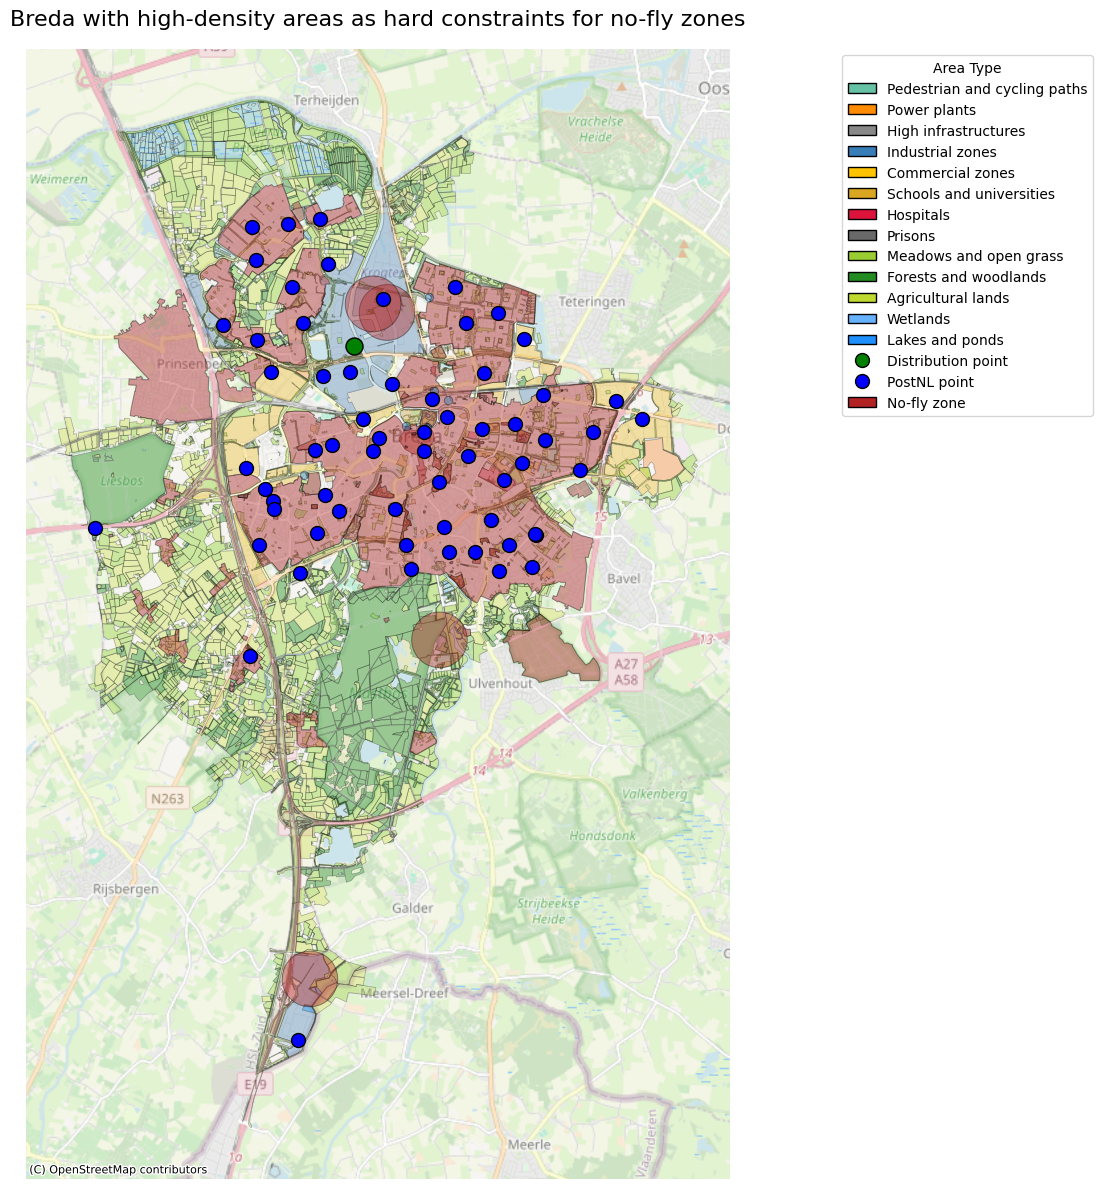

In [8]:
fig1 = plot_polygons_static(gdf_polygons=polygons_gdf, title="Breda with high-density areas as hard constraints for no-fly zones", no_fly_zones_gdf=no_fly_zones_gdf, postnl_points=post_nl_gdf, focus_radius_km=17)
fig1.savefig(f"/Users/cmartens/Documents/thesis_cf_martens/residential_areas/output/breda_high_density_hard_constraints.pdf", dpi=300, bbox_inches='tight')

In [9]:
# Calculate the percentage of PostNL points within no-fly zones for each city
percentage_breda = calculate_percentage_within_no_fly_zones(post_nl_gdf, no_fly_zones_gdf)

## Alphen aan den Rijn and Waddinxveen

In [10]:
gdf, lines_gdf, polygons_gdf, post_nl_gdf, no_fly_zones_gdf = get_gdfs(data_aw, depot=['Alphen aan den Rijn (NLI)', 'Waddinxveen'])

Getting separate dataframes for lines, polygons, postnl points, distribution points and no fly zones
Looking for distribution points in ['Alphen aan den Rijn (NLI)', 'Waddinxveen']
Found 2 distribution points in ['Alphen aan den Rijn (NLI)', 'Waddinxveen']
Found 22830 lines, 8880 polygons, 83 postnl points, 2 distribution point and 260 no-fly zones


/var/folders/3h/vvx1fk6x4knb13xtks19w_zh0000gp/T/ipykernel_77045/1795688204.py:75: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf_web.unary_union.centroid


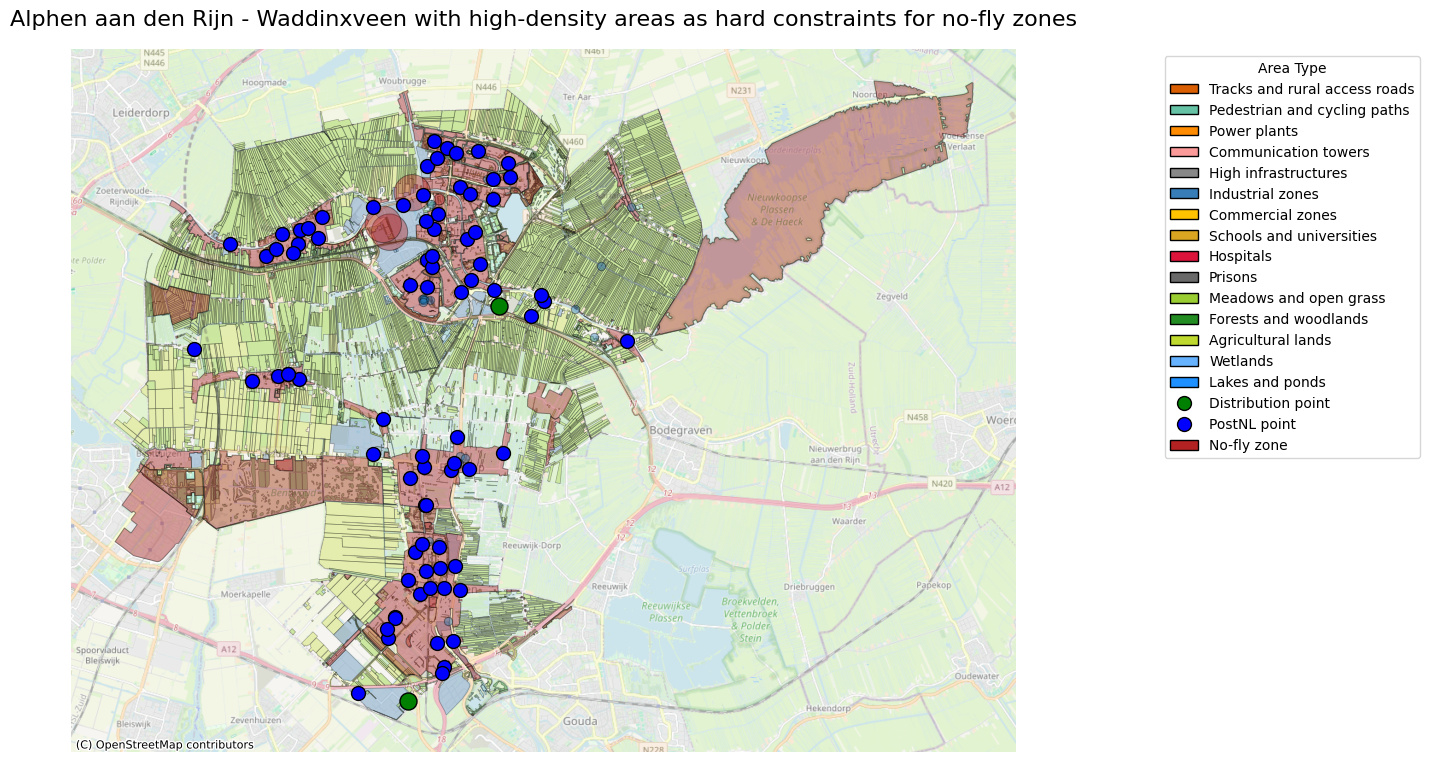

In [11]:
fig3 = plot_polygons_static(gdf_polygons=polygons_gdf, title="Alphen aan den Rijn - Waddinxveen with high-density areas as hard constraints for no-fly zones", no_fly_zones_gdf=no_fly_zones_gdf, postnl_points=post_nl_gdf, focus_radius_km=17)
fig3.savefig(f"/Users/cmartens/Documents/thesis_cf_martens/residential_areas/output/alphen_high_density_hard_constraints.pdf", dpi=300, bbox_inches='tight')

In [12]:
percentage_aw = calculate_percentage_within_no_fly_zones(post_nl_gdf, no_fly_zones_gdf)

## Borsele

In [13]:
def plot_polygons_static(gdf_polygons, city_name="Unknown",
                         no_fly_zones_gdf=None, postnl_points=None, title=None, focus_radius_km=20):
    """
    Plot area-type polygons with consistent color coding on a static background map,
    including optional overlays for no-fly zones and PostNL/distribution points.

    Args:
        gdf_polygons (GeoDataFrame): Polygons with an 'area_type' column and EPSG:28992 CRS.
        city_name (str): Name of the city to use in the plot title.
        no_fly_zones_gdf (GeoDataFrame): Optional. Polygons representing no-fly zones.
        postnl_points (GeoDataFrame): Optional. Points with 'ntype' column: 'postnl' or 'distribution'.

    Returns:
        matplotlib.figure.Figure: The generated matplotlib figure.
    """

    import matplotlib.pyplot as plt
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    import contextily as ctx

    area_color_map = {
        # Infrastructuur
        'Motorways and major roads': '#E31A1C',       # felrood
        'Regional roads': '#F46D43',                  # vurig oranje
        'Tracks and rural access roads': '#D95F02',   # donkeroranje
        'Living and residential streets': '#FFCB05',  # felgeel
        'Pedestrian and cycling paths': '#66C2A5',    # turquoisegroen
        'Railways': '#4B4B4B',                        # donkergrijs
        'Helipads': '#F0027F',
        'Airports and airfields': '#A6CEE3',

        # Energie & communicatie
        'Power lines': '#999999',
        'Power plants': '#FF8C00',
        'Communication towers': '#FB9A99',
        'High infrastructures': '#888888',

        # Gebouwd gebied
        'Industrial zones': '#377EB8',               # helderblauw
        'Commercial zones': '#FFC300',               # goudgeel
        'Retail zones': '#FF8C00',                   # warm oranje
        'Residential areas': '#FFA07A',              # warm zalm/oranjerood – beter onderscheid met 'Retail zones'
        'Schools and universities': '#DAA520',
        'Hospitals': '#DC143C',
        'Care homes': '#FF9999',
        'Prisons': '#696969',
        'Religious sites': '#C71585',
        'Cemeteries': '#556B2F',
        'Cultural sites': '#8A2BE2',

        # Natuur
        'Parks': '#7CFC00',                          # limegroen
        'Recreational zones': '#20B2AA',
        'Meadows and open grass': '#9ACD32',         # geelgroen
        'Forests and woodlands': '#228B22',          # bosgroen
        'Agricultural lands': '#BFD92E',             # helderder dan '#ADDE87'
        'Wetlands': '#66B2FF',                       # licht, helder blauw
        'Lakes and ponds': '#1E90FF',                # diepblauw (meer contrast met 'Wetlands')
        'Water reservoirs': '#4682B4',
        'Rivers, canals and streams': '#5DADE2',
        'Natura2000 areas': '#005824',

        # Overig
        'connector': '#D3D3D3',
        'No-fly zone': '#B22222'
    }
    if gdf_polygons.empty:
        raise ValueError("GeoDataFrame is empty – no polygons to plot.")

    # Project to Web Mercator
    gdf_web = gdf_polygons.to_crs(epsg=3857)

    # Bereken middelpunt van alle polygonen
    centroid = gdf_web.unary_union.centroid
    x0, y0 = centroid.x, centroid.y

    # Zet radius om naar meters
    buffer_m = focus_radius_km * 1000

    # Stel bounds in: min/max x/y
    xlim = (x0 - buffer_m, x0 + buffer_m)
    ylim = (y0 - buffer_m, y0 + buffer_m)

    gdf_web["color"] = gdf_web["area_type"].map(area_color_map).fillna("#cccccc")

    if no_fly_zones_gdf is not None and not no_fly_zones_gdf.empty:
        # Filter expliciet op 'No-fly zone'
        no_fly_zones_filtered = no_fly_zones_gdf[no_fly_zones_gdf['area_type'] == 'No-fly zone']
        no_fly_zones_web = no_fly_zones_filtered.to_crs(epsg=3857)

    if postnl_points is not None:
        postnl_points_web = postnl_points.to_crs(epsg=3857)

    # Plot setup
    fig, ax = plt.subplots(figsize=(14, 12))
    gdf_web.plot(ax=ax, facecolor=gdf_web["color"], edgecolor='black', alpha=0.3, linewidth=0.5)

    if no_fly_zones_gdf is not None:
        no_fly_zones_web.plot(ax=ax, facecolor="#B22222", edgecolor='black', alpha=0.4, linewidth=0.7)

    # Plot PostNL & distribution points with scatter for better control
    if postnl_points is not None:
        if 'area_type' in postnl_points.columns:
            for area_type, group in postnl_points_web.groupby("area_type"):
                if area_type == "distribution":
                    ax.scatter(
                        group.geometry.x, group.geometry.y,
                        marker='o', s=150, c='green', edgecolors='black',
                        label='Distribution point', zorder=6
                    )
                elif area_type == "postnl point":
                    ax.scatter(
                        group.geometry.x, group.geometry.y,
                        marker='o', s=100, c='blue', edgecolors='black',
                        label='PostNL point', zorder=6
                    )
                else:
                    ax.scatter(
                        group.geometry.x, group.geometry.y,
                        marker='x', s=80, c='grey', edgecolors='black',
                        label=f'Other: {area_type}', zorder=6
                    )
        else:
            ax.scatter(
                postnl_points_web.geometry.x, postnl_points_web.geometry.y,
                marker='o', s=100, c='blue', edgecolors='black',
                label='PostNL points', zorder=6
            )

    # Basemap
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.6, zoom=12)

    # Title and formatting
    ax.set_title(f"{title}", fontsize=16)
    ax.set_axis_off()

    # Legend
    used_types = gdf_web["area_type"].unique()
    legend_patches = [
        Patch(facecolor=color, edgecolor='black', label=atype)
        for atype, color in area_color_map.items()
        if atype in used_types
    ]

    if postnl_points is not None:
        legend_patches.append(Line2D([0], [0], marker='o', color='w', markerfacecolor='green',
                                     markeredgecolor='black', markersize=10, label='Distribution point'))
        legend_patches.append(Line2D([0], [0], marker='o', color='w', markerfacecolor='blue',
                                     markeredgecolor='black', markersize=10, label='PostNL point'))

    if no_fly_zones_gdf is not None and not no_fly_zones_gdf.empty:
        legend_patches.append(Patch(facecolor='#B22222', edgecolor='black', label='No-fly zone'))

    ax.legend(
        handles=legend_patches,
        title="Area Type",
        loc="upper left",
        bbox_to_anchor=(1.15, 1)
    )

    plt.tight_layout()
    return fig


In [14]:
gdf, lines_gdf, polygons_gdf, post_nl_gdf, no_fly_zones_gdf = get_gdfs(data_borsele, depot=['Goes'])

Getting separate dataframes for lines, polygons, postnl points, distribution points and no fly zones
Looking for distribution points in ['Goes']
Found 1 distribution points in ['Goes']
Found 5309 lines, 4891 polygons, 24 postnl points, 1 distribution point and 53 no-fly zones


/var/folders/3h/vvx1fk6x4knb13xtks19w_zh0000gp/T/ipykernel_77045/1282093988.py:75: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf_web.unary_union.centroid


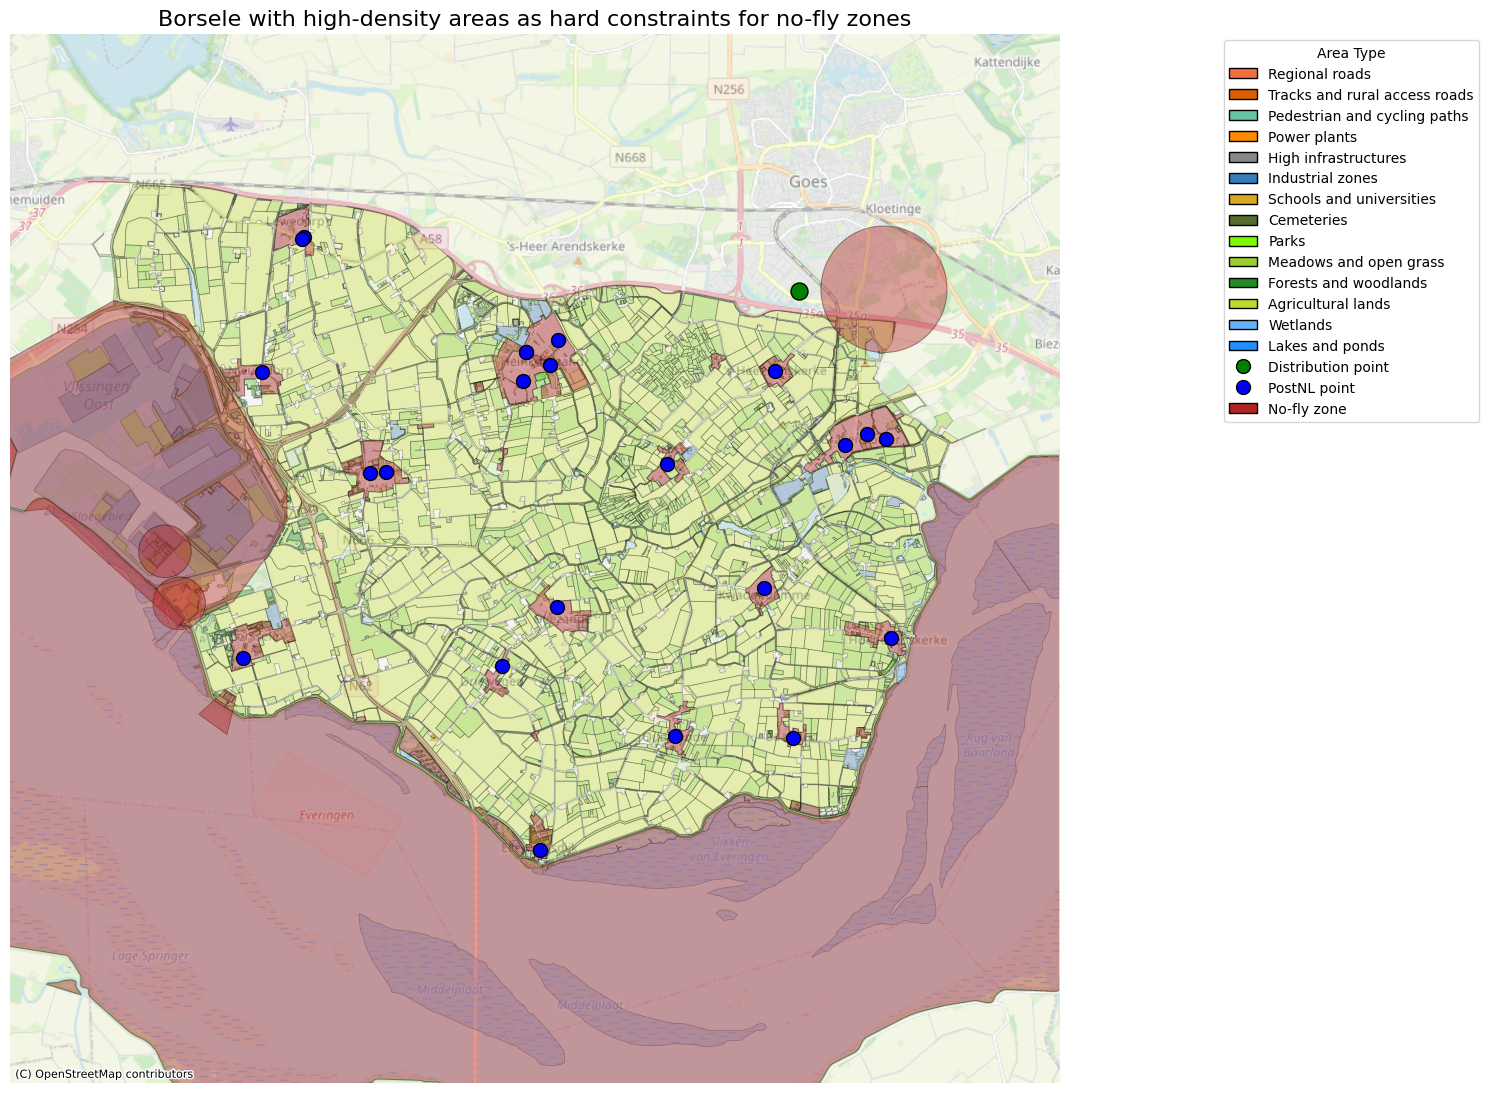

In [15]:
fig2 = plot_polygons_static(gdf_polygons=polygons_gdf, city_name="Goes", no_fly_zones_gdf=no_fly_zones_gdf, postnl_points=post_nl_gdf, title='Borsele with high-density areas as hard constraints for no-fly zones', focus_radius_km=16)
fig2.savefig(f"/Users/cmartens/Documents/thesis_cf_martens/residential_areas/output/borsele_high_density_hard_constraints.pdf", dpi=300, bbox_inches='tight')

In [16]:
percentage_borsele = calculate_percentage_within_no_fly_zones(post_nl_gdf, no_fly_zones_gdf)

## Operational coverage

In [17]:
print(f"Percentage of PostNL points within no-fly zones in Breda: {percentage_breda:.2f}%")
print(f"Percentage of PostNL points within no-fly zones in Borsele: {percentage_borsele:.2f}%")
print(f"Percentage of PostNL points within no-fly zones in Alphen aan den Rijn: {percentage_aw:.2f}%")

Percentage of PostNL points within no-fly zones in Breda: 78.46%
Percentage of PostNL points within no-fly zones in Borsele: 95.83%
Percentage of PostNL points within no-fly zones in Alphen aan den Rijn: 81.93%
